<a href="https://colab.research.google.com/github/Erike-Simon/CESAR-AED/blob/main/MinText_aula5_desafio_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade em Grupo

**CESAR School Recife**

**Disciplina:** *Mineração de Textos*

**Alunos:**

* Arthur Emílio Perruci
* Jadeilson Santos
* José Aparecido Silvano de Albuquerque
* Marcel Pinheiro Caraciolo
* Erike Simon Costa Cativo do Nascimento

## Considere para essa atividade o notebook Aula 04.

Vamos fazer uma análise de um dataset de sentimento, para isso, escolha um dataset qualquer, recomendo pegar um do Kaggle
https://www.kaggle.com/datasets?search=sentiment+analysis

Faça a análise dos dados e responda as perguntas:

1. Sobre oque são os dados?
2. Que tipo de limpeza de dados vocês fizeram?
3. Quais são os termos mais frequêntes?
4. Qual o balanciamento dos dados?
5. Considere que vocês devem expandir essa base de dados
  - Quais as fontes de dados vocês podem usar?
  - Descreva como vocês iriam coletar esses dados?

# Desafio em grupo

Implemente um modelo de classificação a escolha do grupo.




# Tratamento dos dados

Imports iniciais

In [ ]:
!pip install nltk spacy wordcloud

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

import pandas as pd
import numpy as np
import spacy
import nltk
import re

nltk.download('punkt') # tokenizador
nltk.download('stopwords') # baixa uma lista de stop words
nltk.download('wordnet') # baixa o lematizador

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Qual o dataset escolhido?
Escolhemos um dataset que contém reviews de hoteis no Trip Advisor.

Link para o dataset:  https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews/

In [ ]:
url = 'https://raw.githubusercontent.com/aparecidoSilvano/pos-cesar-datasets/main/tripadvisor_hotel_reviews.csv'
df = pd.read_csv(url)

## Sobre o que são os dados?

Hotéis desempenham um papel crucial em viagens e, com o aumento do acesso à informação, novos caminhos para selecionar os melhores surgiram. Com este conjunto de dados, composto por 20 mil avaliações coletadas do Tripadvisor, você pode explorar o que faz um ótimo hotel e talvez até mesmo utilizar este modelo em suas viagens!

```

Citation
Alam, M. H., Ryu, W.-J., Lee, S., 2016. Joint multi-grain topic sentiment: modeling semantic aspects for online reviews. Information Sciences 339, 206–223.
```



In [ ]:
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [ ]:
df['Review'][:10][1]

'ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unlike kimpton calls suite, 5 day stay offer correct false advertising, send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty did not reply solution, send email trip guest survey did not follow email mail, guess tell concerned guest.the staff ranged indifferent not helpful, asked desk good breakfast spots neighborhood hood told no hotels, gee best breakfast spots seattle 1/2 block away convenient hotel does not know exist, arrived late night 11 pm inside run bellman bu

In [ ]:
df['Review'][:10][2]

"nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized, missed 3 separate wakeup calls, concierge busy hard touch, did n't provide guidance special requests.tv hard use ipod sound dock suite non functioning. decided book mediterranean suite 3 night weekend stay 1st choice rest party filled, comparison w spent 45 night larger square footage room great soaking tub whirlpool jets nice shower.before stay hotel arrange car service price 53 tip reasonable driver waiting arrival.checkin easy downside room picked 2 person jacuzi tub no bath accessories salts bubble bath did n't stay, night got 12/1a checked voucher bottle champagne nice gesture fish waiting room, impression room huge open space felt room big, tv far away bed chore change channel, ipod dock broken disappointing.in morning way asked desk check thermostat said 6

In [ ]:
df['Review'][:10][3]

"unique, great stay, wonderful time hotel monaco, location excellent short stroll main downtown shopping area, pet friendly room showed no signs animal hair smells, monaco suite sleeping area big striped curtains pulled closed nice touch felt cosy, goldfish named brandi enjoyed, did n't partake free wine coffee/tea service lobby thought great feature, great staff friendly, free wireless internet hotel worked suite 2 laptops, decor lovely eclectic mix pattens color palatte, animal print bathrobes feel like rock stars, nice did n't look like sterile chain hotel hotel personality excellent stay,  "

## Que tipo de limpeza de dados vocês fizeram?

Função para encapsular todas as etapas comuns de pré-processamento dos textos contidos em *df['review']*

In [ ]:
def text_clean(data):

    # converte todos os textos para minúsculas e remove apóstrofos. A remoção de apóstrofos ajuda a
    # evitar diferentes formas de palavras devido a variações como "it's" e "its", por exemplo
    text_lower = [text.lower().replace("'", '') for text in data]

    # remove todos os caracteres especiais e mantem apenas caracteres alfabéticos
    text_lower = [re.sub("[^a-zA-Z]+", ' ', text) for text in text_lower]

    # tokenização de termos
    text_token = [word_tokenize(text) for text in text_lower]

    # remoção de stopwords
    stop_words = list(set(stopwords.words('english'))-{'not', 'no', 'but', 'don', 'won'})
    text_remstop = []
    for text in text_token:
        text_remstop.append([word for word in text if word not in stop_words])

    # lemmatização dos termos
    text_lemm = []
    wordnet_lemmatizer = WordNetLemmatizer()
    for text in text_remstop:
        text_lemm.append([wordnet_lemmatizer.lemmatize(word) for word in text])

    # remoção de contextual words
    con_words = ['hotel', 'room', 'service', 'resort']
    text_remcon = []
    for text in text_lemm:
        text_remcon.append([word for word in text if word.strip() not in con_words])

    # reconstrução do texto após todas as etapas de pré-processamento, unindo as palavras de volta em frases
    clean_text = [' '.join(text) for text in text_remcon]

    return clean_text

In [ ]:
df_clean = text_clean(df['Review'])

Observando as diferenças entre o texto antes e depois da limpeza.

In [ ]:
df_clean[0]

'nice expensive parking got good deal stay anniversary arrived late evening took advice previous review valet parking check quick easy little disappointed non existent view clean nice size bed comfortable woke stiff neck high pillow not soundproof like heard music night morning loud bang door opening closing hear people talking hallway maybe noisy neighbor aveda bath product nice not goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience pay parking night'

In [ ]:
df['Review'][0]

'nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  '

## Quais são os termos mais frequêntes?

### Termos mais frequentes todos os reviews

Nuvem de palavras

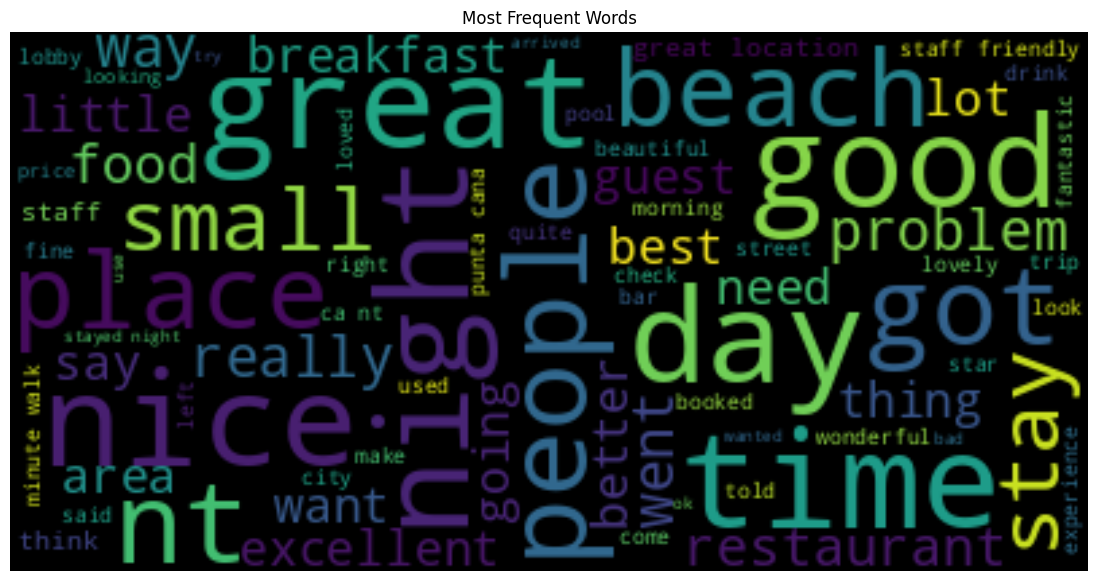

In [ ]:
reviews = ' '.join(df_clean)
wordcloud = WordCloud(max_font_size = 50, max_words = 75, background_color = "black").generate(reviews)

# Display the generated image
plt.figure(figsize = (15, 7))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title("Most Frequent Words")
plt.axis("off")
plt.show()

Utilização da classe *CountVectorizer* do scikit-learn pra extrair bigramas (pares consecutivos de palavras) a partir de um conjunto de documentos pré-processados

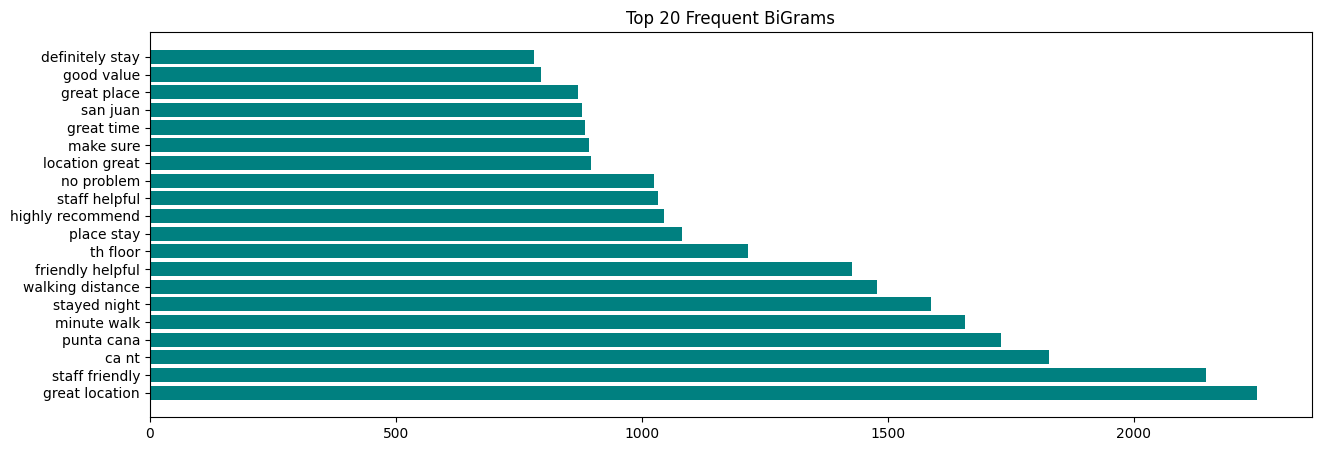

In [ ]:
CV = CountVectorizer(ngram_range = (2, 2), analyzer = 'word') # cria a instância da classe
sparse_matrix = CV.fit_transform(df_clean) # transforma os documentos em uma matriz esparsa onde as linhas representam documentos,
                                           # as colunas os bigramas e os valores representam as contagens de ocorrências de cada bigrama nos docs
frequencies = sum(sparse_matrix).toarray()[0] # soma as contagens de ocorrências de cada bigrama ao longo de todos os documentos
                                              # 'toarray()' converte a matriz esparsa em uma matriz densa

#  dataframe pra armazenar as contagens de frequência de cada bigrama.
bigram_df = pd.DataFrame(frequencies, index=CV.get_feature_names_out(), columns=['frequency'])
top20_bigrams = bigram_df.sort_values(by = "frequency", ascending=False).head(20) # coleta os 20 bigramas de maior ocorrência

plt.figure(figsize = (15, 5))
plt.barh(width = top20_bigrams.frequency.values, y = top20_bigrams.index, color = 'teal')
plt.title("Top 20 Frequent BiGrams")
plt.xlabel('Frequency')
plt.ylabel('BiGrams')
plt.show()

### Termos mais frequentes -  reviews positivos (Nota 4 e 5)

In [ ]:
df_new = pd.DataFrame({'review': df_clean, 'rating': df['Rating']})
df_new.head()

,review,rating
0,nice expensive parking got good deal stay anni...,4
1,ok nothing special charge diamond member hilto...,2
2,nice not experience monaco seattle good nt lev...,3
3,unique great stay wonderful time monaco locati...,5
4,great stay great stay went seahawk game awesom...,5


Nuvem de palavras para reviews positivos

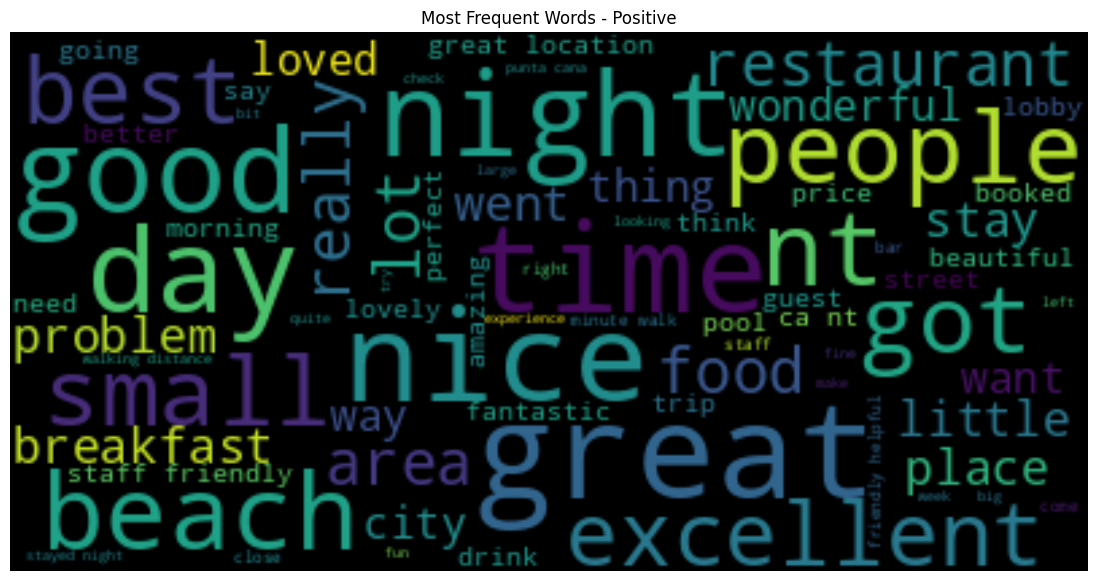

In [ ]:
reviews = ' '.join(df_new[df_new['rating'].isin([4,5])]['review'])
wordcloud = WordCloud(max_font_size = 50, max_words = 75, background_color = "black").generate(reviews)

plt.figure(figsize = (15, 7))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title("Most Frequent Words - Positive")
plt.axis("off")
plt.show()

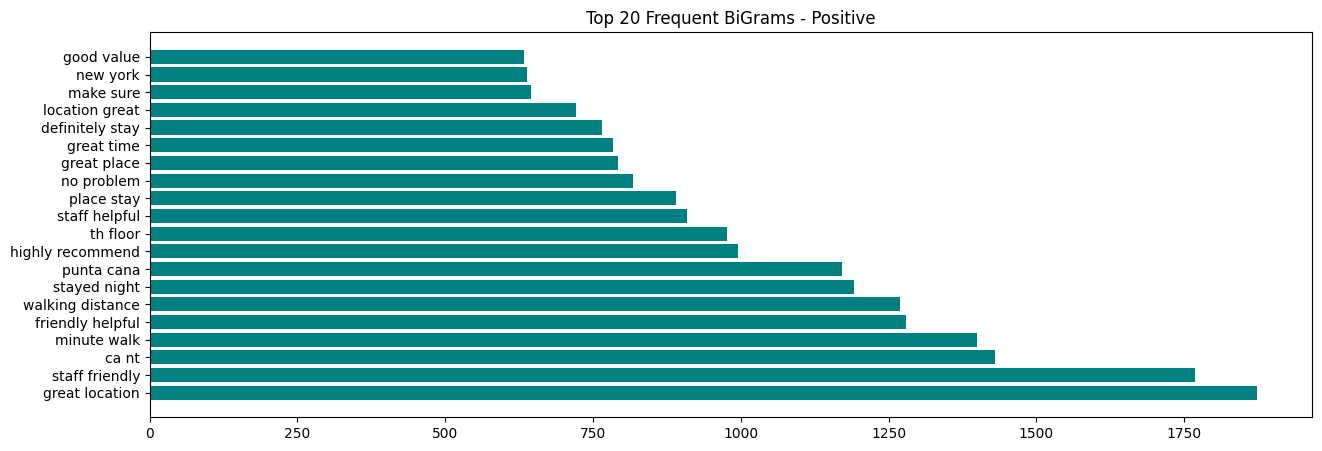

In [ ]:
CV = CountVectorizer(ngram_range = (2, 2), analyzer = 'word')
sparse_matrix = CV.fit_transform(df_new[df_new['rating'].isin([4,5])]['review'])
frequencies = sum(sparse_matrix).toarray()[0]
bigram_df = pd.DataFrame(frequencies, index=CV.get_feature_names_out(), columns=['frequency'])
top20_bigrams = bigram_df.sort_values(by = "frequency", ascending=False).head(20)

plt.figure(figsize = (15, 5))
plt.barh(width = top20_bigrams.frequency.values, y = top20_bigrams.index, color = 'teal')
plt.title("Top 20 Frequent BiGrams - Positive")
plt.xlabel('Frequency')
plt.ylabel('BiGrams')
plt.show()

### Termos mais frequentes - reviews negativos (Nota 1 e 2)

Nuvem de palavras para reviews negativos

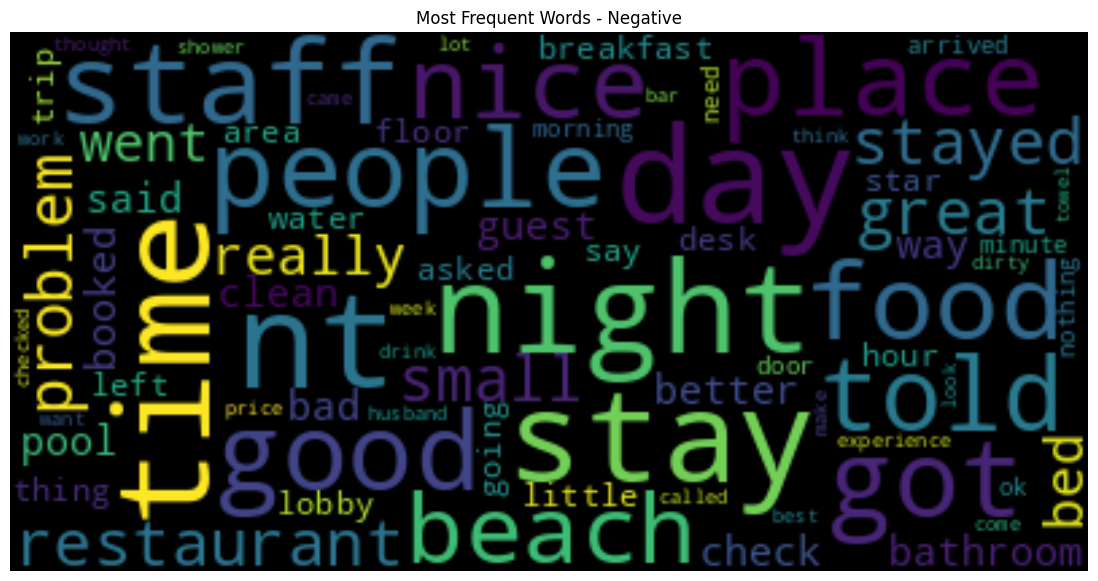

In [ ]:
reviews = ' '.join(df_new[df_new['rating'].isin([1,2])]['review'])
wordcloud = WordCloud(max_font_size = 50, max_words = 75, background_color = "black").generate(reviews)
#Display the generated image
plt.figure(figsize = (15, 7))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title("Most Frequent Words - Negative")
plt.axis("off")
plt.show()

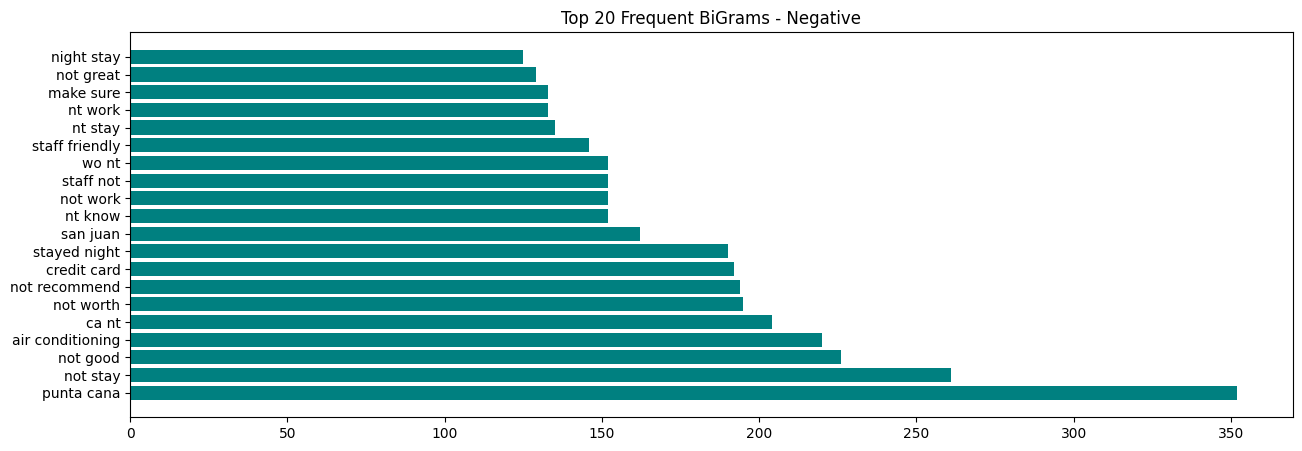

In [ ]:
CV = CountVectorizer(ngram_range = (2, 2), analyzer = 'word')
sparse_matrix = CV.fit_transform(df_new[df_new['rating'].isin([1,2])]['review'])
frequencies = sum(sparse_matrix).toarray()[0]
bigram_df = pd.DataFrame(frequencies, index=CV.get_feature_names_out(), columns=['frequency'])
top20_bigrams = bigram_df.sort_values(by = "frequency", ascending=False).head(20)

plt.figure(figsize = (15, 5))
plt.barh(width = top20_bigrams.frequency.values, y = top20_bigrams.index, color = 'teal')
plt.title("Top 20 Frequent BiGrams - Negative")
plt.xlabel('Frequency')
plt.ylabel('BiGrams')
plt.show()

## Qual o balanciamento dos dados?

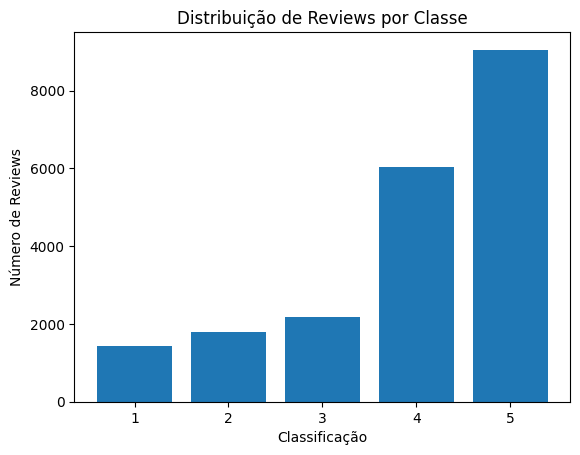

In [ ]:
counts = df['Rating'].value_counts()

plt.bar(counts.index, counts.values)
plt.xlabel('Classificação')
plt.ylabel('Número de Reviews')
plt.title('Distribuição de Reviews por Classe')
plt.show()

A quantidade de avaliações positivas é muito superior as demais classificações. Para contornar esse problema vamos aplicar a técnica de sub-amostragem dos dados.

Primeiro vamos criar um novo dataset onde a classificação que se dá através de valores númericos vai ser convertida para um valor representativo. Vamos considerar que as notas 4 e 5 são equivalentes a uma classificação positiva, notas 3 são neutras e notas 1 e 2 são negativas.

Vamos fazer isso afim de simplificar a nossa variável alvo e poder aumentar o número de exemplos no balanceamento.

Fazendo mapeando dos valores de score para os valores "POSITIVE", "NEGATIVE", e "NEUTRAL".

In [ ]:
new_df = pd.DataFrame({'review': df_clean, 'Rating': df['Rating'], 'classification': df['Rating'].map({5: 'POSITIVE', 4: 'POSITIVE', 3: 'NEUTRAL', 2: 'NEGATIVE', 1: 'NEGATIVE'})})
new_df.head()

,review,Rating,classification
0,nice expensive parking got good deal stay anni...,4,POSITIVE
1,ok nothing special charge diamond member hilto...,2,NEGATIVE
2,nice not experience monaco seattle good nt lev...,3,NEUTRAL
3,unique great stay wonderful time monaco locati...,5,POSITIVE
4,great stay great stay went seahawk game awesom...,5,POSITIVE


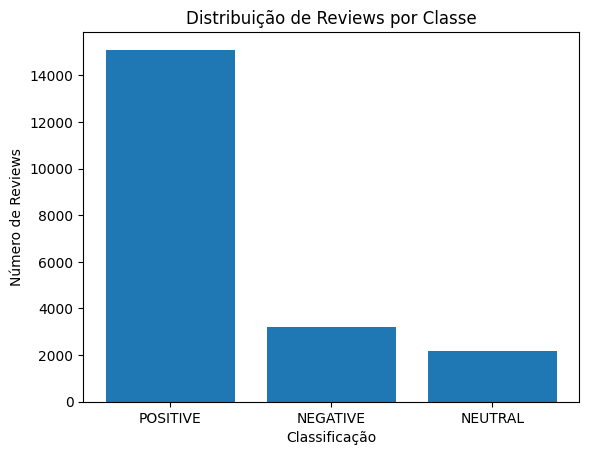

In [ ]:
counts = new_df['classification'].value_counts()

plt.bar(counts.index, counts.values)
plt.xlabel('Classificação')
plt.ylabel('Número de Reviews')
plt.title('Distribuição de Reviews por Classe')
plt.show()

Aplicando técnica de sub-amostragem para contornar problema de balanceamento dos dados.

O objetivo do balanceamento é igualar o número de amostras em cada classe, tornando o conjunto de dados mais equilibrado. Útil em problemas de classificação com classes com quantidades muito diferentes de amostras entre si, avitando assim desequilíbrios no treinamento do modelo.

In [ ]:
import pandas as pd
from sklearn.utils import resample

# Supondo que 'new_df' seja o DataFrame com as colunas 'review' e 'classification'
# Separar o DataFrame por classes de opinião
positive_reviews = new_df[new_df['classification'] == 'POSITIVE']
neutral_reviews = new_df[new_df['classification'] == 'NEUTRAL']
negative_reviews = new_df[new_df['classification'] == 'NEGATIVE']

# Determinar o número mínimo de amostras em qualquer uma das classes
min_samples = min(len(positive_reviews), len(neutral_reviews), len(negative_reviews))

# Subamostrar cada classe para o mesmo número de amostras da classe menos representada
# 'replace=False' indica que a subamostragem deve ser feita sem reposição.
positive_reviews_balanced = resample(positive_reviews, replace=False, n_samples=min_samples, random_state=42)
neutral_reviews_balanced = resample(neutral_reviews, replace=False, n_samples=min_samples, random_state=42)
negative_reviews_balanced = resample(negative_reviews, replace=False, n_samples=min_samples, random_state=42)

# Criar o DataFrame final balanceado
balanced_dataset = pd.concat([positive_reviews_balanced, neutral_reviews_balanced, negative_reviews_balanced])

# O conjunto de dados resultante é embaralhado para garantir que as amostras não mantenham a ordem original.
# O método '.sample()' com 'frac=1' realiza o embaralhamento, e '.reset_index(drop=True)' recria os índices do DataFrame embaralhado.
balanced_dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Exibir a contagem de amostras por classe
print(balanced_dataset['classification'].value_counts())


POSITIVE    2184
NEUTRAL     2184
NEGATIVE    2184
Name: classification, dtype: int64


Como ficou a distribuição dos dados após o balanceamento?

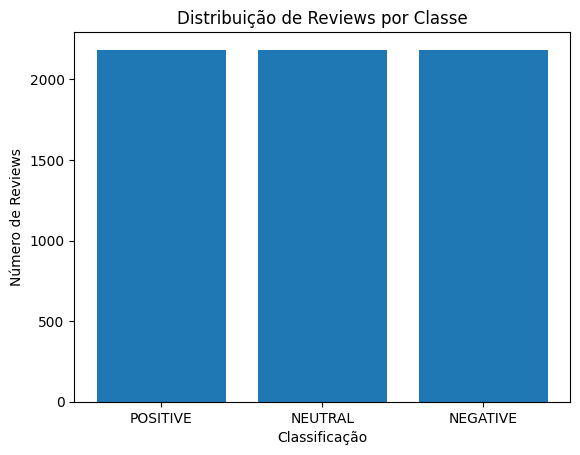

In [ ]:
counts = balanced_dataset['classification'].value_counts()

plt.bar(counts.index, counts.values)
plt.xlabel('Classificação')
plt.ylabel('Número de Reviews')
plt.title('Distribuição de Reviews por Classe')
plt.show()

## Considere que vocês devem expandir essa base de dados

### Quais as fontes de dados vocês podem usar?

Podemos ter fontes de dados de outros sites de reviews de hotéis como Booking, Google Reviews.

### Descreva como vocês iriam coletar esses dados?

- Por meio de webcrawlers usando Selenium ou BeautifulSoup para extração dos reviews com respectivas notas ou via Kaggle de Datasets que já provem reviews como:

https://www.kaggle.com/datasets/thedevastator/30000-booking-com-reviews-for-hotels-worldwide

https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe


# Criação do modelo de classificação 1

- Neste modelo vamos utilizar os rótulos labels com a transformação da variável alvo numérica em categórica (POSITIVO, NEUTRO, NEGATIVO).

Divisão em conjuntos de treino, teste e validação.

In [ ]:
from sklearn.model_selection import train_test_split

# Supondo que 'balanced_dataset' seja o DataFrame balanceado
X = balanced_dataset['review']  # Recursos (features)
y = balanced_dataset['classification']   # Rótulos (labels)

# Dividir o conjunto de dados em treinamento (80%) e teste + validação (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Dividir o conjunto de teste + validação em teste (50%) e validação (50%)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Agora temos 'X_train', 'y_train', 'X_test', 'y_test', 'X_val' e 'y_val' como conjuntos separados
# 'X_val' e 'y_val' são usados para ajustar hiperparâmetros do modelo e evitar overfitting.

In [ ]:
print("Conjunto de Treinamento:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("\nConjunto de Teste:")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

print("\nConjunto de Validação:")
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)


Conjunto de Treinamento:
X_train shape: (5241,)
y_train shape: (5241,)

Conjunto de Teste:
X_test shape: (655,)
y_test shape: (655,)

Conjunto de Validação:
X_val shape: (656,)
y_val shape: (656,)


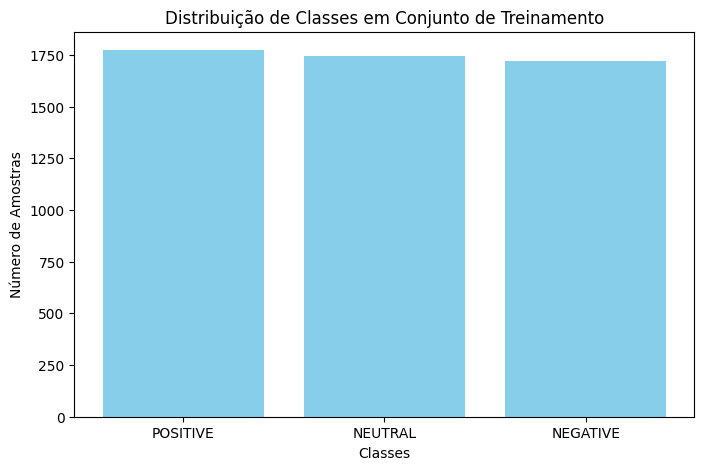

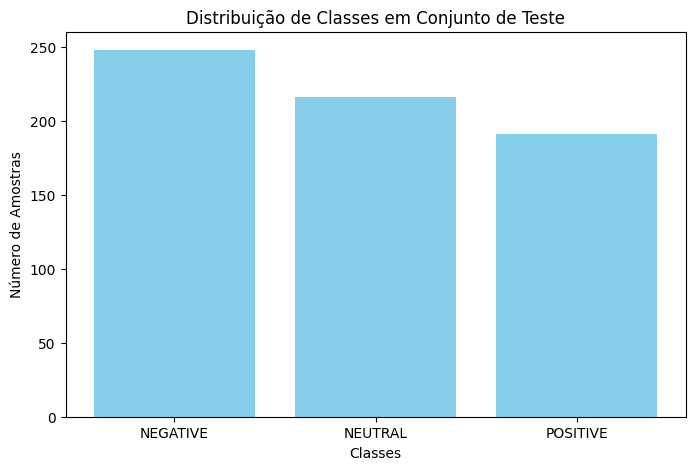

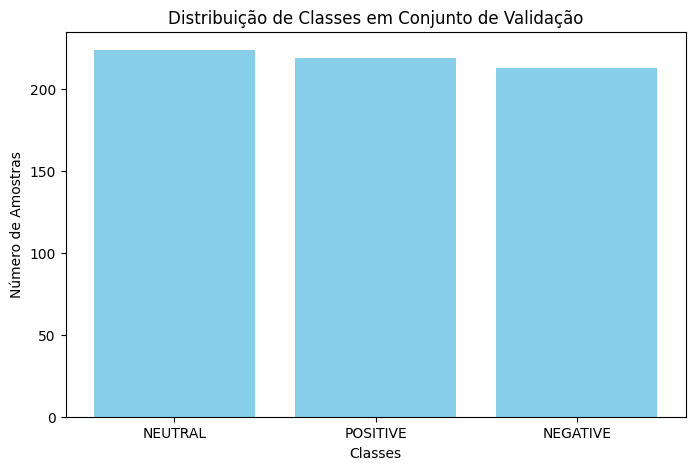

In [ ]:
import matplotlib.pyplot as plt

def plot_class_distribution(y, dataset_name):
    plt.figure(figsize=(8, 5))
    plt.bar(y.value_counts().index, y.value_counts().values, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Número de Amostras')
    plt.title(f'Distribuição de Classes em {dataset_name}')
    plt.show()

# Verificar o equilíbrio de classes nos conjuntos de treino, teste e validação
plot_class_distribution(y_train, 'Conjunto de Treinamento')
plot_class_distribution(y_test, 'Conjunto de Teste')
plot_class_distribution(y_val, 'Conjunto de Validação')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

# Criar o pipeline com o TF-IDF e o classificador Random Forest
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),  # Ajuste max_features conforme necessário
    ('rf', RandomForestClassifier(random_state=42))
])

# Treinamento do modelo no conjunto de de dados de treinamento
#  pipeline oferece uma abordagem completa desde o pré-processamento dos dados (usando TF-IDF)
# até a construção e treinamento do modelo (Random Forest).
pipeline.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = pipeline.predict(X_test)

# Avaliar o desempenho
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia no conjunto de teste: {accuracy:.2f}')

# Exibir o relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

Acurácia no conjunto de teste: 0.68

Relatório de Classificação:
              precision    recall  f1-score   support

    NEGATIVE       0.81      0.75      0.78       248
     NEUTRAL       0.57      0.51      0.54       216
    POSITIVE       0.65      0.79      0.71       191

    accuracy                           0.68       655
   macro avg       0.68      0.68      0.68       655
weighted avg       0.68      0.68      0.68       655



Análise dos resultados para o modelo:

- O modelo parece ter um bom desempenho para a classe NEGATIVE, com uma acurácia geral razoável;
- A classe NEUTRAL possui um desempenho moderado em relação as outras duas classes, tendo todas as suas métricas mais baixas;
- Também com um desempenho bom, temos a classe POSITIVE, tendo 'recall' maior do que a classe NEGATIVE.

# Criação do modelo de classificação 2

- Neste modelo vamos utilizar os rótulos numéricos sem nenhuma transformação.

- Utilizaremos o modelo de regressão *RandomForest* e com o componente de busca de hiper-parâmetros por meio do GridSearch.

In [ ]:
from sklearn.model_selection import train_test_split

# Supondo que 'balanced_dataset' seja o DataFrame balanceado
X = balanced_dataset['review']  # Recursos (features)
y = balanced_dataset['Rating']   # Rótulos (scores)

# Dividir o conjunto de dados em treinamento (80%) e teste + validação (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Dividir o conjunto de teste + validação em teste (50%) e validação (50%)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
print("Conjunto de Treinamento:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("\nConjunto de Teste:")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

print("\nConjunto de Validação:")
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)


Conjunto de Treinamento:
X_train shape: (5241,)
y_train shape: (5241,)

Conjunto de Teste:
X_test shape: (655,)
y_test shape: (655,)

Conjunto de Validação:
X_val shape: (656,)
y_val shape: (656,)


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5241,)
(655,)
(5241,)
(655,)


In [ ]:
# vectorize the data using Tfidfvectorizer
vectorizer = TfidfVectorizer()

In [ ]:
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

Profundidade 5

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, accuracy_score

rf = RandomForestRegressor(max_depth = 5, random_state=42)
rf.fit(X_train_vec, y_train)

RandomForestRegressor(max_depth=5, random_state=42)

In [ ]:
rf_pred = rf.predict(X_test_vec)

print('mean squared error for random forest regressor with tree depth=5: ', mean_squared_error(rf_pred, y_test)**0.5)

mean squared error for random forest regressor with tree depth=5:  1.092929505636754


profundidade 30

In [ ]:
rf_30 = RandomForestRegressor(max_depth = 30, random_state=42)
rf_30.fit(X_train_vec, y_train)

RandomForestRegressor(max_depth=30, random_state=42)

In [ ]:
rf_30_pred = rf_30.predict(X_test_vec)
print('mean squared error for random forest regressor with tree depth: 30: ', mean_squared_error(rf_30_pred, y_test)**0.5)

mean squared error for random forest regressor with tree depth: 30:  0.9435738969827427


##### Hyper parameter tuning using GridSearchCV



Realiza um *Grid Search* para otimizar os hiperparâmetros de um modelo de regressão *Random Forest*

In [ ]:
# Create the parameter grid based on the results of random search
param_grid = {
    'max_features': [500, "sqrt", "log2", "auto"],
    'max_depth': [10, 15, 25]
}

In [ ]:
rf_new = RandomForestRegressor(random_state=42)

In [ ]:
# Instantiate the grid search model
from sklearn.model_selection import  GridSearchCV

grid_search = GridSearchCV(estimator = rf_new, param_grid = param_grid,
                          cv = 5, n_jobs = -1, verbose = 1, scoring = "neg_mean_squared_error" )

# Executa a pesquisa em grade treinando o modelo para todas as combinações de hiperparâmetros e validação cruzada.
grid_search.fit(X_train_vec, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 15, 25],
                         'max_features': [500, 'sqrt', 'log2', 'auto']},
             scoring='neg_mean_squared_error', verbose=1)

Parâmetros

* estimator=rf_new: O modelo que será otimizado.
* param_grid=param_grid: O grid de parâmetros a ser testado.
* cv=5: Especifica validação cruzada com 5 folds.
* n_jobs=-1: Utiliza todos os núcleos disponíveis para acelerar o processo.
* verbose=1: Exibe mensagens de progresso durante a pesquisa.
* scoring="neg_mean_squared_error": Usa o erro quadrático médio negativo como métrica de avaliação.

In [ ]:
grid_search_pred = grid_search.predict(X_test_vec)

In [ ]:
# modelo com os melhores hiperparâmetros encontrados durante a
grid_search.best_estimator_

RandomForestRegressor(max_depth=25, max_features='auto', random_state=42)

In [ ]:
grid_best_est_pred = grid_search.best_estimator_.predict(X_test_vec)
print('mean squared error with hypertuning parameters: ', mean_squared_error(y_test, grid_best_est_pred ) ** 0.5)

mean squared error with hypertuning parameters:  0.9464919469014667


In [ ]:
res_df = pd.DataFrame({'review':X_test, 'rating':y_test, 'rating_pred':grid_best_est_pred})

# Filtrando o DataFrame para mostrar apenas as linhas onde a diferença entre a avaliação real e a
# previsão é maior que 2, ajudando assim a identificar casos em que o modelo comete grandes erros.
res_df[(res_df.rating - res_df.rating_pred) > 2]

,review,rating,rating_pred
2776,magnificent returned week trip italy ended tra...,5,2.519361
3916,city centre luxury central equipped affordable...,5,2.979805
544,comfortable vey large maintained beautifully d...,5,2.827449
4697,place minimalism delivers not feel living para...,5,2.300116
2623,amazing personal not tell impressed level staf...,5,2.680873
4633,fantastic not recommend staff excellent partic...,5,2.524773
5079,sunscape spectacular august heard read review ...,5,2.484844
5965,nice location not good season hard time decidi...,5,2.716087
5152,quality quiet right middle thing fantastic c n...,5,2.401797
6494,classy took wife american long weekend booked ...,5,2.353964


**Conclusão**

* Observa-se que a configuração com 'max_depth = 30' obteve um desempenho ligeiramente melhor em termos de MSE em comparação com a configuração anterior com 'max_depth = 5'.

* A otimização adicional dos hiperparâmetros resultou em um MSE semelhante ao obtido com 'max_depth = 30', indicando que neste caso, a profundidade da árvore pode ter sido um fator mais determinante do que outros hiperparâmetros testados.

Em conclusão, o ajuste de hiperparâmetros teve algum impacto no desempenho do modelo, mas a escolha da profundidade da árvore desempenhou um papel mais relevante.